# 1. Installing requirements

Just run the cell below to configure the environment and install packages for this work

In [ ]:
# create environment and install requirements
!python3 -m venv .venv
!source .venv/bin/activate
!pip install -r requirements.txt

# 2. Framing the problem

## 2.1 Goal

We want to predict an Airbnb housing price, based in some aspects of a thousand of orders grouped in a huge dataset
- Features like location, review score, how many bedrooms, etc.


## 2.2 Algorithm

- Learning 
  - **Supervised learning**
    - We're predicting housing prices, a known target variable within our dataset.
  - **Batch learning**
    - We're training on the entire Kaggle dataset at once ! We have the dataset split into months, but since we aren't doing time-based forecasting, we'll analyze the entire dataset as a whole.
  - **Model based**
    - We'll create a predictive model to forecast housing prices 
- Model task : **Linear regression**
  - This is a regression problem, as we aim to predict the numerical value of AirBnB housing prices in Brazilian Real.

## 2.3 Performance mesure for evaluation : **RSME or MAE**
Choosing the right performance measure, either RMSE or MAE, **depends heavily on the characteristics of our dataset**, particularly the presence of outliers and the data's distribution.
  - RMSE (Root Mean Squared Error) **is more sensitive to outliers** due to the squaring of errors. This makes it suitable for datasets with a balanced, bell-shaped distribution and few outliers.
  - On the other hand, MAE (Mean Absolute Error) is more robust to outliers as it considers the absolute difference between predictions and actual values. MAE is generally preferred for those with a **significant presence of outliers**.

# 3. Loading the dataset

⚠️ I received a DtypeWarning ! Some columns has mixed types. When we will analyse the dataset, we'll need to handle this.

In [1]:
import pandas as pd
import numpy as np

df_raw = pd.read_csv("data/total_data.csv")

/tmp/ipykernel_97764/4181529510.py:4: DtypeWarning: Columns (1,17,19,20,28,33,34,54,62,63,66,68,69,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("data/total_data.csv")


# 4. First EDA analysis

## 4.1 **.head()** : first glance

We can see, at this first glance, that this dataset has a bunch of textual information, but we're going to predict a numerical value. Let's keep analyzing !

In [4]:
df_raw.head(2)

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,0.0,17878,https://www.airbnb.com/rooms/17878,2.018082e+13,2018-08-16,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,24480,https://www.airbnb.com/rooms/24480,2.018082e+13,2018-08-16,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4.2 **.info()** : value types

We got 72 object-type columns ! More than the half of all the dataset columns. We'll need effectively take a deep look inside, to gather some good information from this columns. The goal is to encode some of them, after filtering the good ones, to numerical. For this, we have two tasks in those object-type columns: 1) identify interesting data and 2) verify if they're able to be encoded.


**"What is encoding ? Why encode ?"**
- As we're doing a linear regression task, our model need to be fed with numerical data. Texts are in string format, then, we need to find a way to transform them ! In NLP cases, we tokenize the text, but here, we're just searching for **categorical features**. After, we need to identify if they're **ordinal** or **numerical** ones. 

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784122 entries, 0 to 784121
Columns: 108 entries, Unnamed: 0 to calculated_host_listings_count_shared_rooms
dtypes: float64(36), object(72)
memory usage: 646.1+ MB


## 4.3 **.nunique()** and **value_counts()**

Let's get deep in those object-like data using two Pandas functions : **.nunique()** and **.value_counts()**.

- **.nunique** counts unique values in a column, while **.value_counts** counts the occurrences of each unique value. 
- The code below aims to identify columns where a small subset of the most frequent values (top 10) accounts for a large proportion of the data (95%). This is useful for understanding the distribution of categorical data and potentially simplifying feature engineering.
- These columns contain interesting categorical values, making them good candidates for encoding.


In [19]:
# filter categorical features

# Select all columns with object type
df_object_type = df_raw.select_dtypes(include='object').astype(str)

list_col = []

for col in df_object_type:
    # count how many unique values in each column
    count = df_object_type[col].nunique()

    # Calculate value counts and cumulative percentage
    value_counts_series = df_object_type[col].value_counts()
    cumulative_percentage = value_counts_series.cumsum() / value_counts_series.sum()

    # Check if top 10 values make up 95% of the data
    if cumulative_percentage.iloc[min(4, len(cumulative_percentage) - 1)] >= 0.95:
        # Get the top 10 unique values
        top_10_unique_values = value_counts_series.head(10).index.tolist()
        print(f"Column '{col}' has {count} unique values and its top 10 values make up 95% of the data: {top_10_unique_values}")

Column 'experiences_offered' has 2 unique values and its top 10 values make up 95% of the data: ['none', '1.0']
Column 'medium_url' has 2 unique values and its top 10 values make up 95% of the data: ['nan', 'Rio de Janeiro']
Column 'xl_picture_url' has 2 unique values and its top 10 values make up 95% of the data: ['nan', '22060-020']
Column 'host_response_time' has 6 unique values and its top 10 values make up 95% of the data: ['nan', 'within an hour', 'within a few hours', 'within a day', 'a few days or more', 'f']
Column 'host_is_superhost' has 4 unique values and its top 10 values make up 95% of the data: ['f', 't', 'nan', '3']
Column 'host_has_profile_pic' has 4 unique values and its top 10 values make up 95% of the data: ['t', 'f', 'nan', '$501.00']
Column 'host_identity_verified' has 3 unique values and its top 10 values make up 95% of the data: ['f', 't', 'nan']
Column 'state' has 80 unique values and its top 10 values make up 95% of the data: ['Rio de Janeiro', 'RJ', 'State of

Now we need to justify the selection of each of these rows, which will impact or not the housing price.

To keep :
- 'experiences_offered', 'host_response_time', 'host_is_superhost', 'host_identity_verified',
'is_location_exact', 'property_type', 'room_type', 'bed_type', 'guests_included', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'host_has_profile_pic'

To drop :
- Redundant : 'medium_url', 'xl_picture_url', 'state', 'market', 'country_code', 'country'
- Weird values : 'host_has_profile_pic'

We keep this columns in a selected_column_list. We can't forget to make a good data cleaning
work on them, searching for outliars (invalid values)

In [21]:
selected_cat_col = ['experiences_offered', 'host_response_time', 'host_is_superhost',
    'host_identity_verified', 'is_location_exact', 'property_type', 'room_type',
    'bed_type', 'guests_included', 'instant_bookable', 'cancellation_policy',
    'require_guest_profile_picture', 'host_has_profile_pic']

len(selected_cat_col)

13

## 4.4 **.describe()** : count, mean, min, and max for numerical values

In [33]:
pd.set_option('display.float_format', '{:.2f}'.format)
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,784121.00,17835.10,10314.35,0.00,8910.00,17820.00,26731.00,38173.00
scrape_id,784121.00,20190612401525.64,6566994942.80,20180816030859.00,20190118024059.00,20190619182032.00,20191223164813.00,20200524171540.00
thumbnail_url,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_group_cleansed,1.00,1.00,NaN,1.00,1.00,1.00,1.00,1.00
latitude,784121.00,-22.97,0.08,-23.07,-22.98,-22.97,-22.95,43.00
longitude,784121.00,-43.25,0.14,-43.74,-43.32,-43.20,-43.19,43.00
bathrooms,782628.00,1.69,1.22,0.00,1.00,1.00,2.00,200.00
bedrooms,783346.00,1.64,1.08,0.00,1.00,1.00,2.00,45.00
beds,781787.00,2.60,2.07,0.00,1.00,2.00,3.00,86.00
square_feet,12018.00,511.10,937.14,0.00,0.00,194.00,753.00,10764.00


## 4.5 **.hist** : histogram from numerical features

The analysis of the numerical features revealed that many histograms exhibit a tail-heavy distribution, meaning they extend further to the right of the median than to the left. This skewness might pose challenges for certain Machine Learning algorithms in identifying patterns effectively. To address this, transformations will be applied to these attributes later with the aim of achieving more bell-shaped distributions, which are often preferred for many ML algorithms.

In [22]:
import matplotlib.pyplot as plt

df_numerical = df_raw.select_dtypes(exclude="object")
df_numerical = df_numerical.drop(columns=["Unnamed: 0", "scrape_id", "thumbnail_url", "jurisdiction_names"])
len(df_numerical.columns)

32

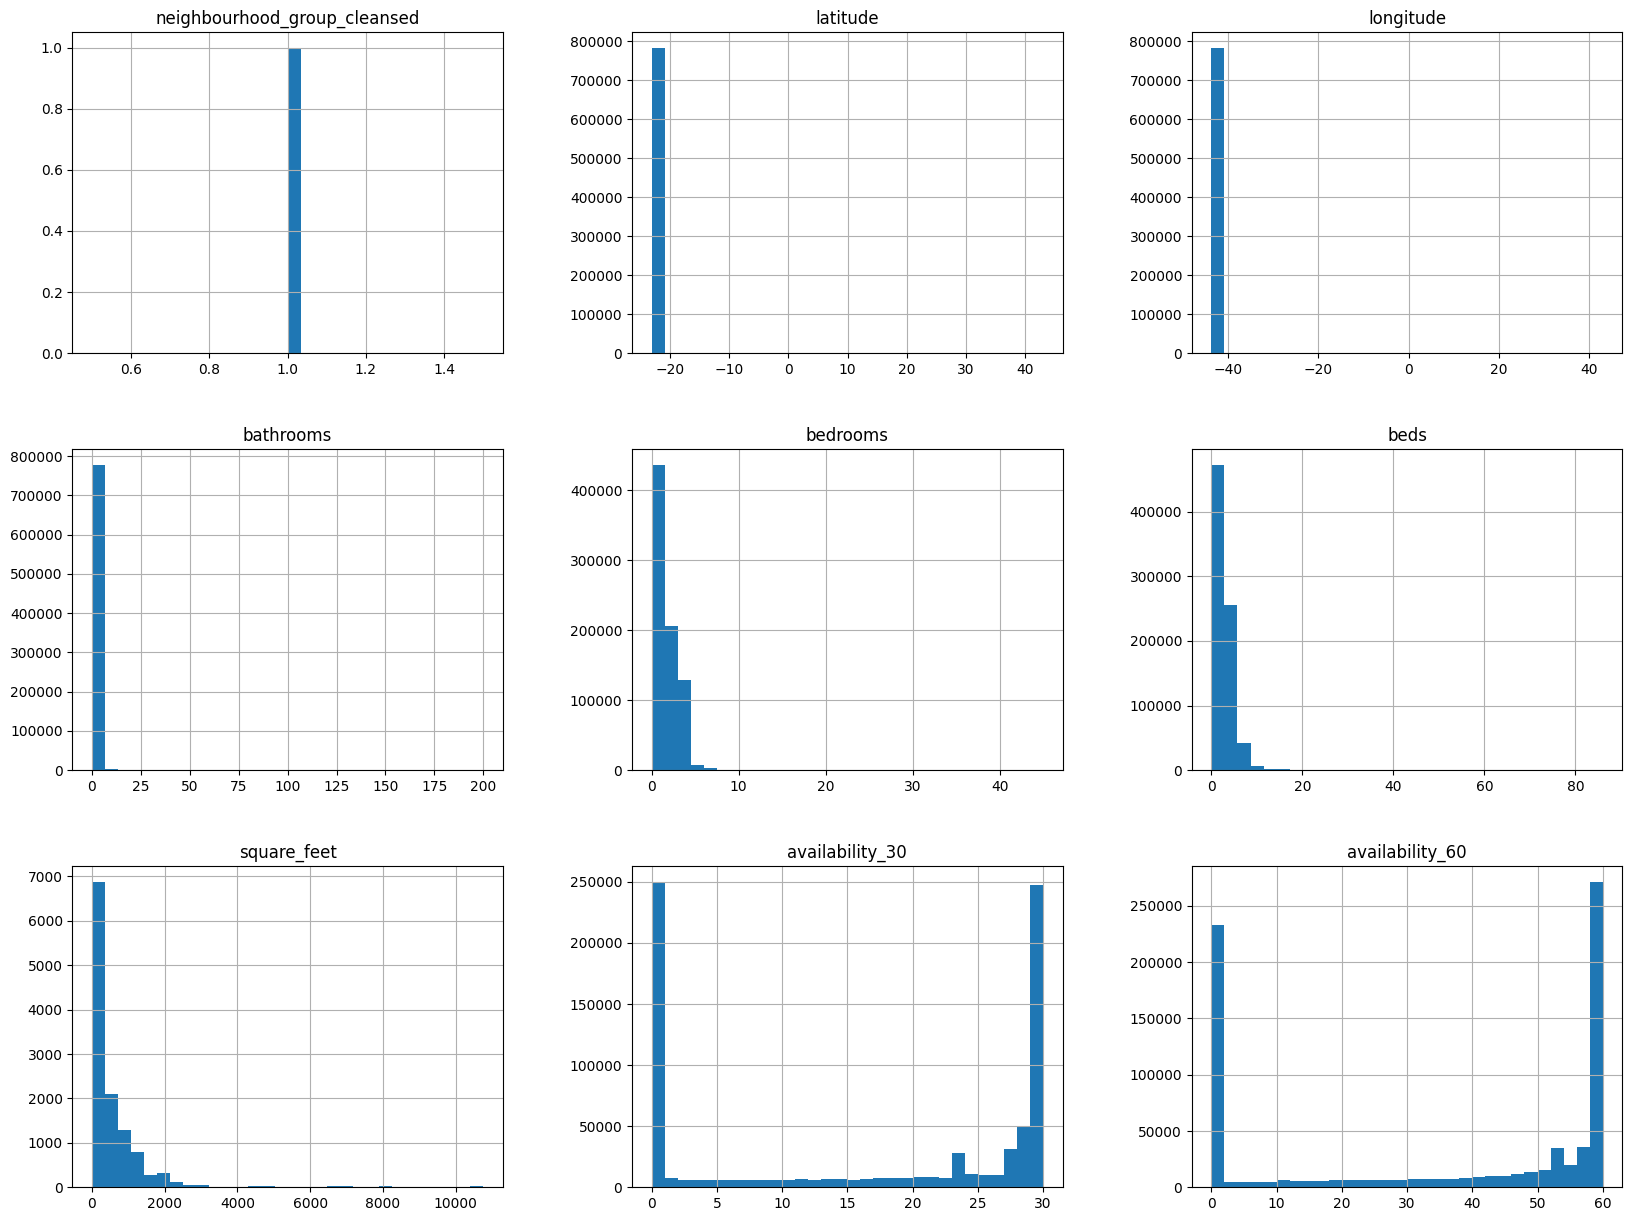

In [29]:
df_num_1 = df_numerical.iloc[:,0:9]
df_num_1.hist(bins=30, figsize=(20,15))
plt.show()

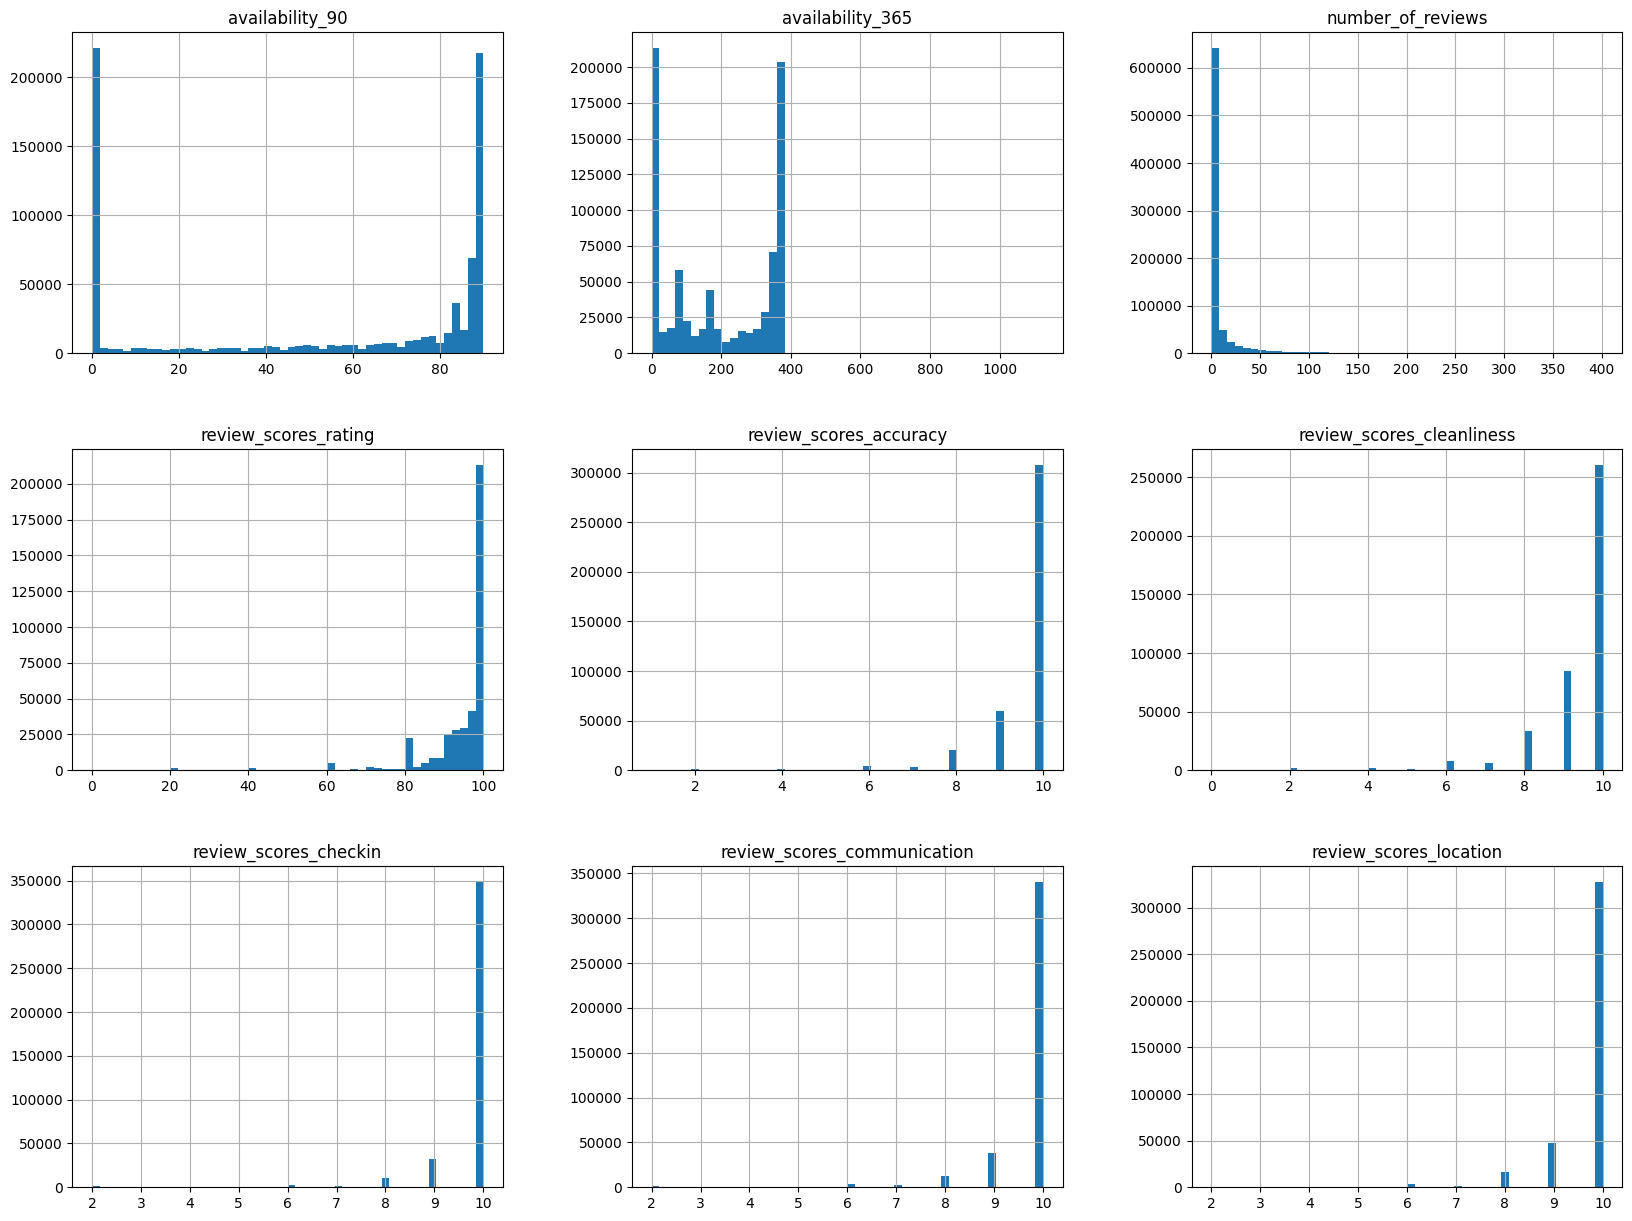

In [24]:
df_num_2 = df_numerical.iloc[:,9:18]
df_num_2.hist(bins=50, figsize=(20,15))
plt.show()

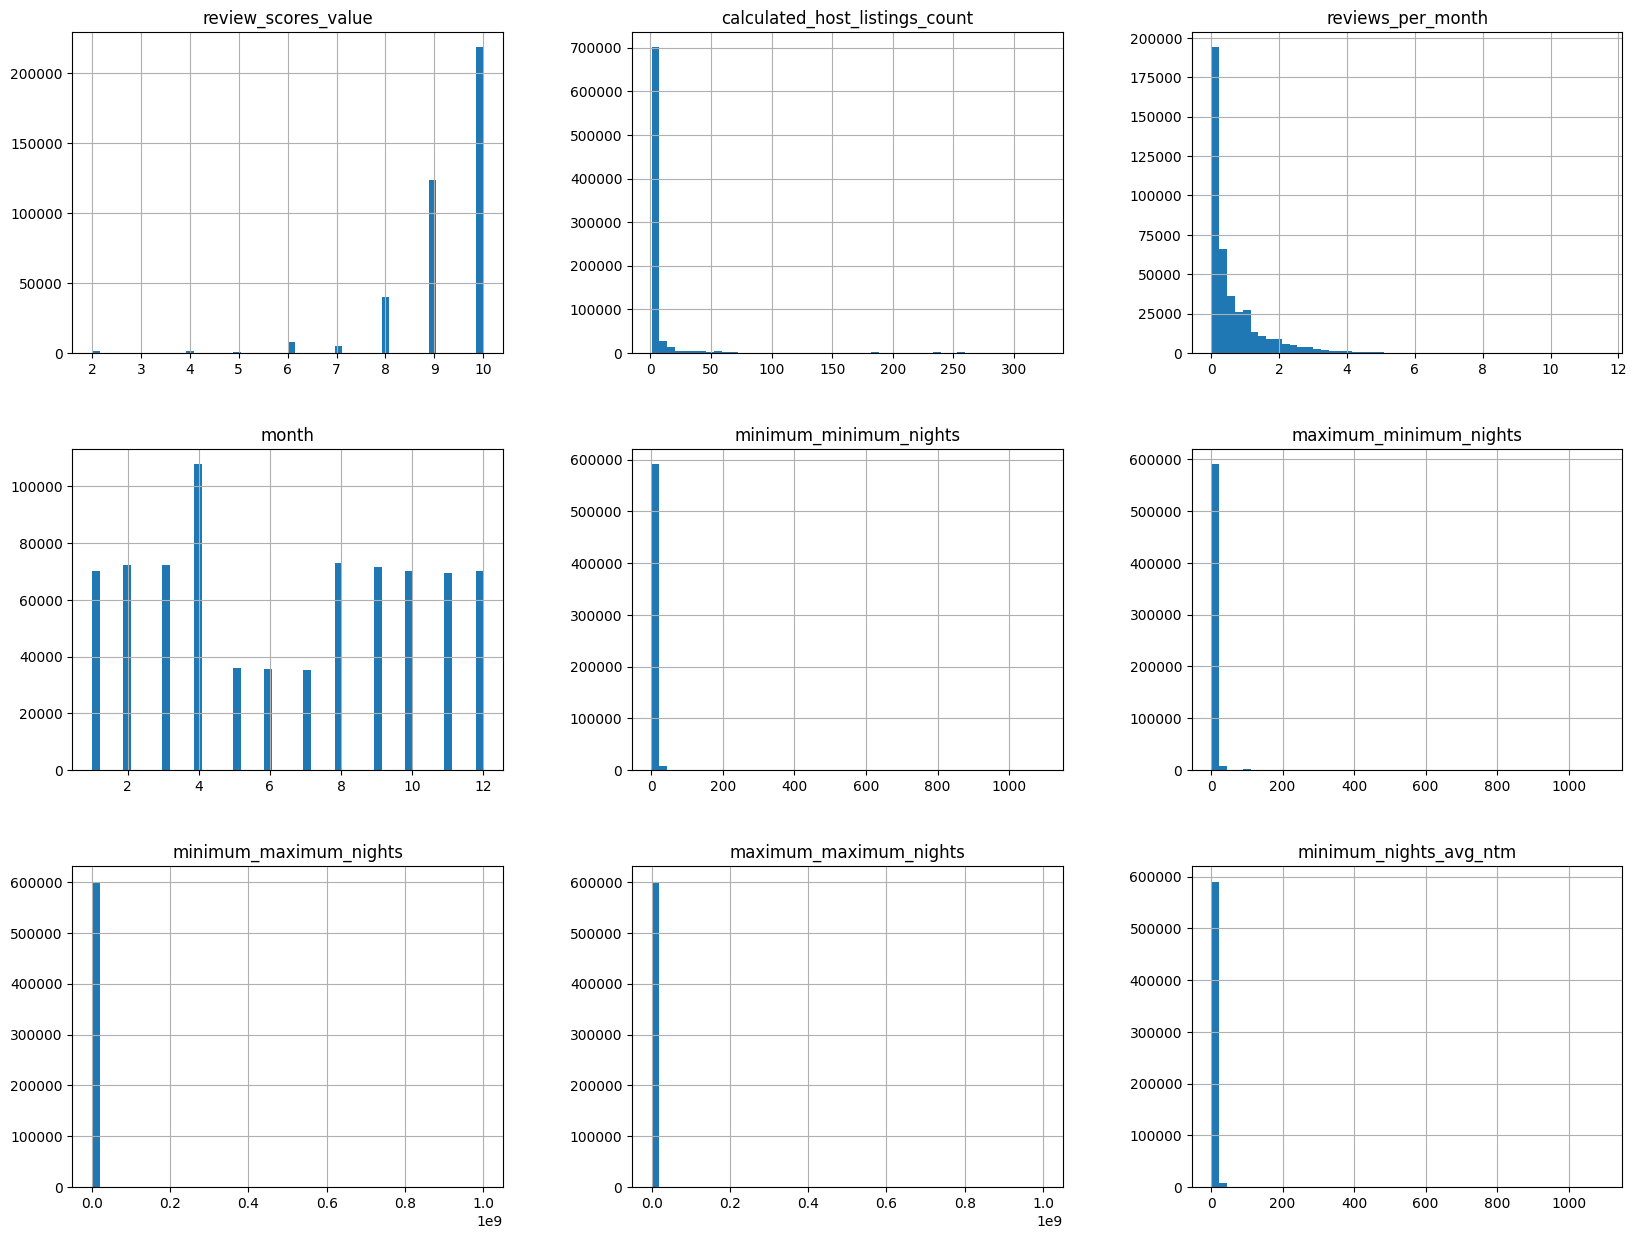

In [25]:
df_num_3 = df_numerical.iloc[:,18:27]
df_num_3.hist(bins=50, figsize=(20,15))
plt.show()

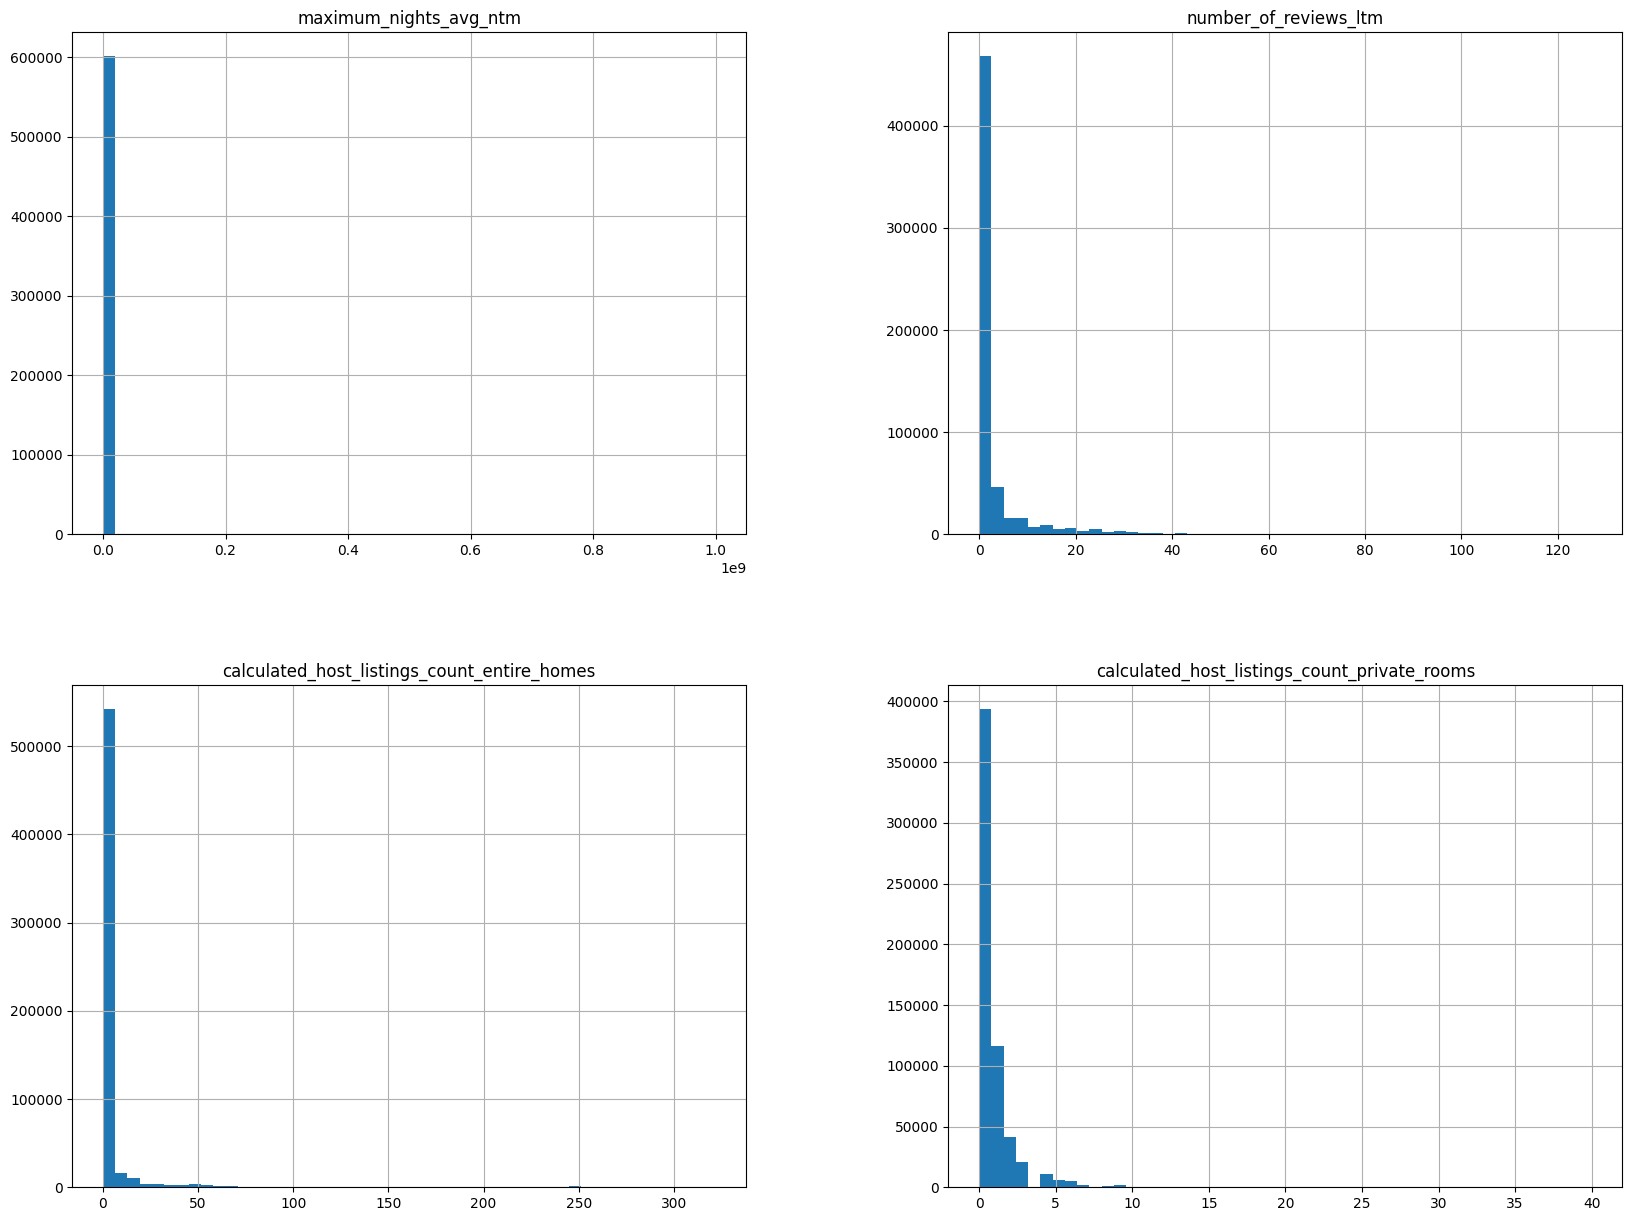

In [26]:
df_num_4 = df_numerical.iloc[:,27:-1]
df_num_4.hist(bins=50, figsize=(20,15))
plt.show()

# 5. Creating a test set

xxx